In [3]:
import pandas as pd
import numpy

In [3]:

from datetime import datetime

# Define the column names as provided
column_names = ['date', 'time', 'epoch', 'moteid', 'temperature', 'humidity', 'light', 'voltage']

# Load the data with proper column names
df = pd.read_csv('data/data.txt', sep=' ', header=None, names=column_names)

# Function to parse the time with fallback for different formats
def parse_time(time_str):
    try:
        return datetime.strptime(time_str, '%H:%M:%S.%f').time()
    except ValueError:
        try:
            return datetime.strptime(time_str, '%H:%M:%S').time()
        except ValueError:
            return None

# Apply the function to the 'time' column
df['time'] = df['time'].apply(parse_time)

# Ensure the 'date' column is parsed correctly
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce').dt.date

# Ensure correct data types for other columns
df['epoch'] = pd.to_numeric(df['epoch'], errors='coerce').astype('Int64')
df['moteid'] = pd.to_numeric(df['moteid'], errors='coerce').astype('Int64')
df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
df['light'] = pd.to_numeric(df['light'], errors='coerce')
df['voltage'] = pd.to_numeric(df['voltage'], errors='coerce')

# Print the last few rows of the dataframe to verify
print(df.tail())

# Optionally, handle any rows where the date or time could not be parsed
invalid_dates = df[df['date'].isna()]
invalid_times = df[df['time'].isna()]

print("Rows with invalid dates:")
print(invalid_dates)

print("Rows with invalid times:")
print(invalid_times)

               date             time  epoch  moteid  temperature  humidity  \
2313677  2004-04-02  01:14:54.164318  61274    <NA>          NaN       NaN   
2313678  2004-04-02  01:17:53.670524  61275    <NA>          NaN       NaN   
2313679  2004-04-02  01:20:52.807972  61276    <NA>          NaN       NaN   
2313680  2004-04-02  01:26:53.950342  61278    <NA>          NaN       NaN   
2313681  2004-04-02  01:35:53.897412  61280    <NA>          NaN       NaN   

         light  voltage  
2313677    NaN      NaN  
2313678    NaN      NaN  
2313679    NaN      NaN  
2313680    NaN      NaN  
2313681    NaN      NaN  
Rows with invalid dates:
Empty DataFrame
Columns: [date, time, epoch, moteid, temperature, humidity, light, voltage]
Index: []
Rows with invalid times:
Empty DataFrame
Columns: [date, time, epoch, moteid, temperature, humidity, light, voltage]
Index: []


In [4]:
df = df.dropna()

# Print the last few rows of the dataframe to verify
len(df)

2219803

In [5]:
top_100_df = df.head(50000)

# Find the number of unique moteid values in the top 100 rows
unique_moteids_count = top_100_df['moteid'].nunique()

print(f'The number of unique moteid values in the top 100 rows is: {unique_moteids_count}')

The number of unique moteid values in the top 100 rows is: 2


In [6]:
# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Parse the 'time' column dynamically
df['time'] = pd.to_datetime(df['time'], errors='coerce', format='%H:%M:%S.%f').dt.time
df['time'] = df['time'].fillna(pd.to_datetime(df['time'], errors='coerce', format='%H:%M:%S').dt.time)

In [7]:
# Remove rows where 'time' could not be parsed (NaT values)
df = df.dropna(subset=['time'])

In [8]:
# Combine 'date' and 'time' into a single 'datetime' column
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))


In [9]:
df = df[df['temperature'] <= 35]

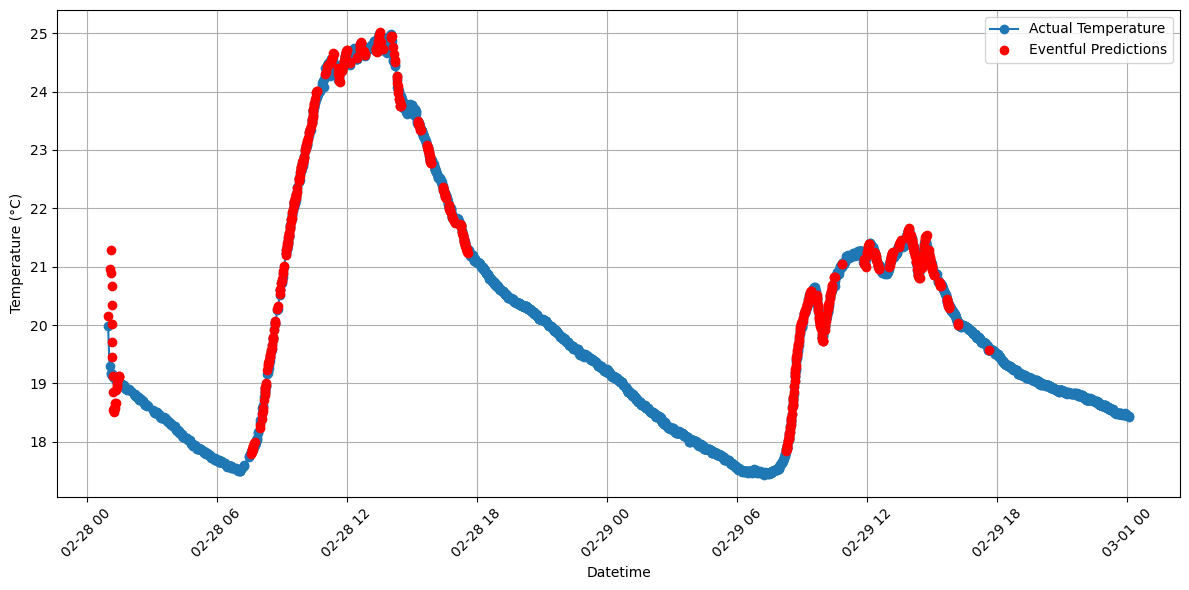

Total number of temperature readings: 3050
Number of eventful predictions: 611


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your existing DataFrame with 'datetime' and 'temperature' columns
# Ensure the 'datetime' column is in datetime format if not already done
df['datetime'] = pd.to_datetime(df['datetime'])

# Use the top 150 rows
top_150_df = df.head(3050)

# Constants for the filter
alpha = 0.2  # Filter coefficient for state update
beta = 0.2  # Filter coefficient for rate of change update
epsilon = 0.01  # Sensitivity threshold for event detection
delta_epsilon = 1e-1  # Small value to avoid division by zero

# Initial conditions
x1 = 20  # Assume initial temperature (state)
x2 = 0.01   # Initial rate of change of temperature
t_previous = top_150_df['datetime'].iloc[0].timestamp()

# Filter and prediction functions
def dEWMA_filter(z, x1, x2, t, t_previous):
    delta_t = t - t_previous
    delta_t = delta_t if delta_t > 0 else delta_epsilon  # Prevent division by zero
    x1_new = alpha * z + (1 - alpha) * (x1 + x2 * delta_t)
    x2_new = beta * (x1_new - x1) / delta_t + (1 - beta) * x2
    return x1_new, x2_new

def predict_sink_state(x1, x2, t, t_sink):
    delta_t = t_sink - t
    y_sink = x1 + x2 * delta_t
    return y_sink

# Apply the dEWWM filter to the actual temperature readings
sink = []
timestamps = []
total_readings = 0
eventful_readings = 0

for index, row in top_150_df.iterrows():
    t_current = row['datetime'].timestamp()
    z = row['temperature']
    x1, x2 = dEWMA_filter(z, x1, x2, t_current, t_previous)
    y_sink = predict_sink_state(x1, x2, t_current, t_current + 32)  # Predict the state 32 seconds into the future

    total_readings += 1  # Increment total readings count

    if abs(y_sink - x1) > epsilon:
        eventful_readings += 1  # Increment eventful readings count
        sink.append(y_sink)
        timestamps.append(row['datetime'])

    t_previous = t_current

# Plot the actual temperature and eventful predictions
plt.figure(figsize=(12, 6))
plt.plot(top_150_df['datetime'], top_150_df['temperature'], label='Actual Temperature', marker='o')
if sink:
    plt.plot(timestamps, sink, 'ro', label='Eventful Predictions')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
#plt.title('Temperature Over Time (Top 150 Rows)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Total number of temperature readings:", total_readings)
print("Number of eventful predictions:", eventful_readings)


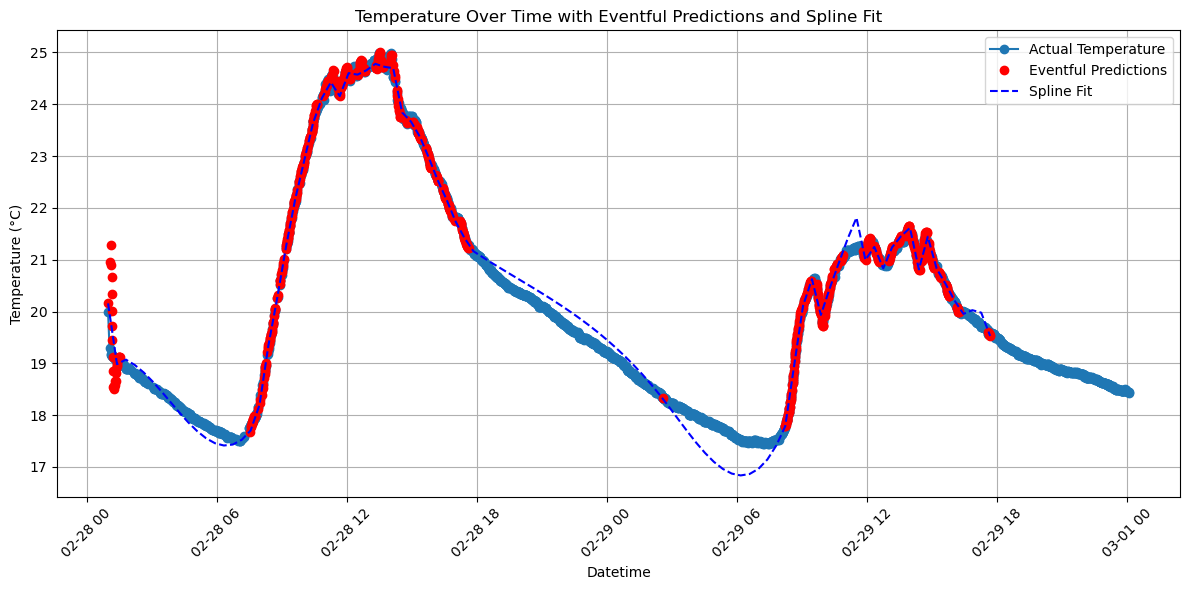

Total number of temperature readings: 3050
Number of eventful predictions: 726


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Assuming df is your existing DataFrame with 'datetime' and 'temperature' columns
# Ensure the 'datetime' column is in datetime format if not already done
df['datetime'] = pd.to_datetime(df['datetime'])

# Use the top 3050 rows
top_3050_df = df.head(3050)

# Constants for the filter
alpha = 0.2  # Filter coefficient for state update
beta = 0.2  # Filter coefficient for rate of change update
epsilon = 0.008  # Sensitivity threshold for event detection
delta_epsilon = 1e-1  # Small value to avoid division by zero

# Initial conditions
x1 = 20  # Assume initial temperature (state)
x2 = 0.01   # Initial rate of change of temperature
t_previous = top_3050_df['datetime'].iloc[0].timestamp()

# Filter and prediction functions
def dEWMA_filter(z, x1, x2, t, t_previous):
    delta_t = t - t_previous
    delta_t = delta_t if delta_t > 0 else delta_epsilon  # Prevent division by zero
    x1_new = alpha * z + (1 - alpha) * (x1 + x2 * delta_t)
    x2_new = beta * (x1_new - x1) / delta_t + (1 - beta) * x2
    return x1_new, x2_new

def predict_sink_state(x1, x2, t, t_sink):
    delta_t = t_sink - t
    y_sink = x1 + x2 * delta_t
    return y_sink

# Apply the dEWMA filter to the actual temperature readings
sink = []
timestamps = []
total_readings = 0
eventful_readings = 0

for index, row in top_3050_df.iterrows():
    t_current = row['datetime'].timestamp()
    z = row['temperature']
    x1, x2 = dEWMA_filter(z, x1, x2, t_current, t_previous)
    y_sink = predict_sink_state(x1, x2, t_current, t_current + 32)  # Predict the state 32 seconds into the future

    total_readings += 1  # Increment total readings count

    if abs(y_sink - x1) > epsilon:
        eventful_readings += 1  # Increment eventful readings count
        sink.append(y_sink)
        timestamps.append(t_current)

    t_previous = t_current

# Fit a spline to the eventful predictions
if sink:
    cs = CubicSpline(timestamps, sink)

    # Generate a dense set of time points for a smooth spline plot
    t_dense = np.linspace(min(timestamps), max(timestamps), 100)
    T_dense = cs(t_dense)

    # Convert the dense time points back to datetime for plotting
    t_dense_datetime = pd.to_datetime(t_dense, unit='s')

# Plot the actual temperature and eventful predictions
plt.figure(figsize=(12, 6))
plt.plot(top_3050_df['datetime'], top_3050_df['temperature'], label='Actual Temperature', marker='o')
if sink:
    plt.plot(pd.to_datetime(timestamps, unit='s'), sink, 'ro', label='Eventful Predictions')
    plt.plot(t_dense_datetime, T_dense, 'b--', label='Spline Fit')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time with Eventful Predictions and Spline Fit')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Total number of temperature readings:", total_readings)
print("Number of eventful predictions:", eventful_readings)
